In [1]:
#importing the necessary modules
import torch
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

import cv2
from skimage import io
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Exploration

In [2]:
#reading data
#Change path to your images and csv files path 
train_data = pd.read_csv('Train .csv')
test_data = pd.read_csv('Test .csv')
train_path = 'data/train/'
test_path = 'data/test/'

In [3]:
# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
#train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']


In [4]:
train.head()

,filepath,LABEL,ID
0,data/train/VTYNBFTO.png,1,VTYNBFTO
1,data/train/GVVXXDOZ.png,0,GVVXXDOZ
2,data/train/PMRSQLXN.png,0,PMRSQLXN
3,data/train/JXISWDUU.png,1,JXISWDUU
4,data/train/JVWMAACC.png,1,JVWMAACC


In [5]:
test.head()

,filepath,ID
0,data/test/GTWSHFYQ.png,GTWSHFYQ
1,data/test/QTFSSMGD.png,QTFSSMGD
2,data/test/TBLBHSYT.png,TBLBHSYT
3,data/test/ZKETEOFG.png,ZKETEOFG
4,data/test/GKTPBGZP.png,GKTPBGZP


In [6]:
print("Train data shape is ",train.shape)
print("Test data  shape is ",test.shape)

Train data shape is  (718, 3)
Test data  shape is  (82, 2)


/home/gerald/anaconda3/envs/tb_zindi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


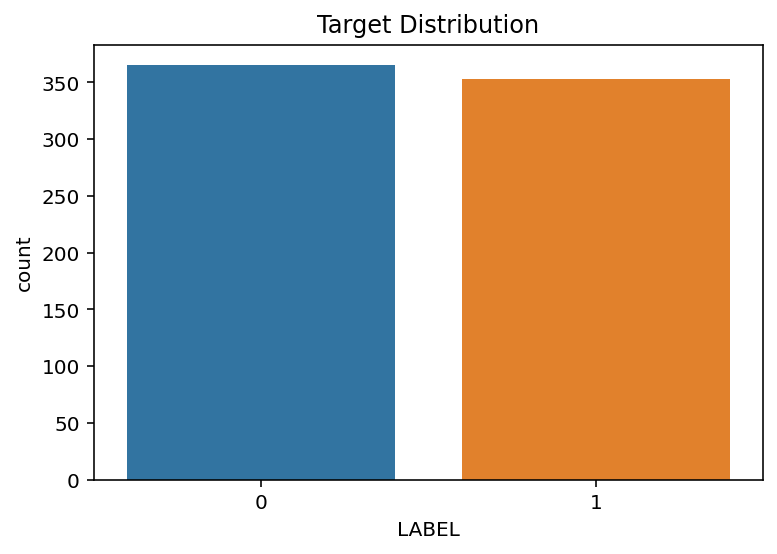

In [7]:
## EDA & PREPROCESSING
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

### Observation
* Our target column seems to be well balanced in the data set

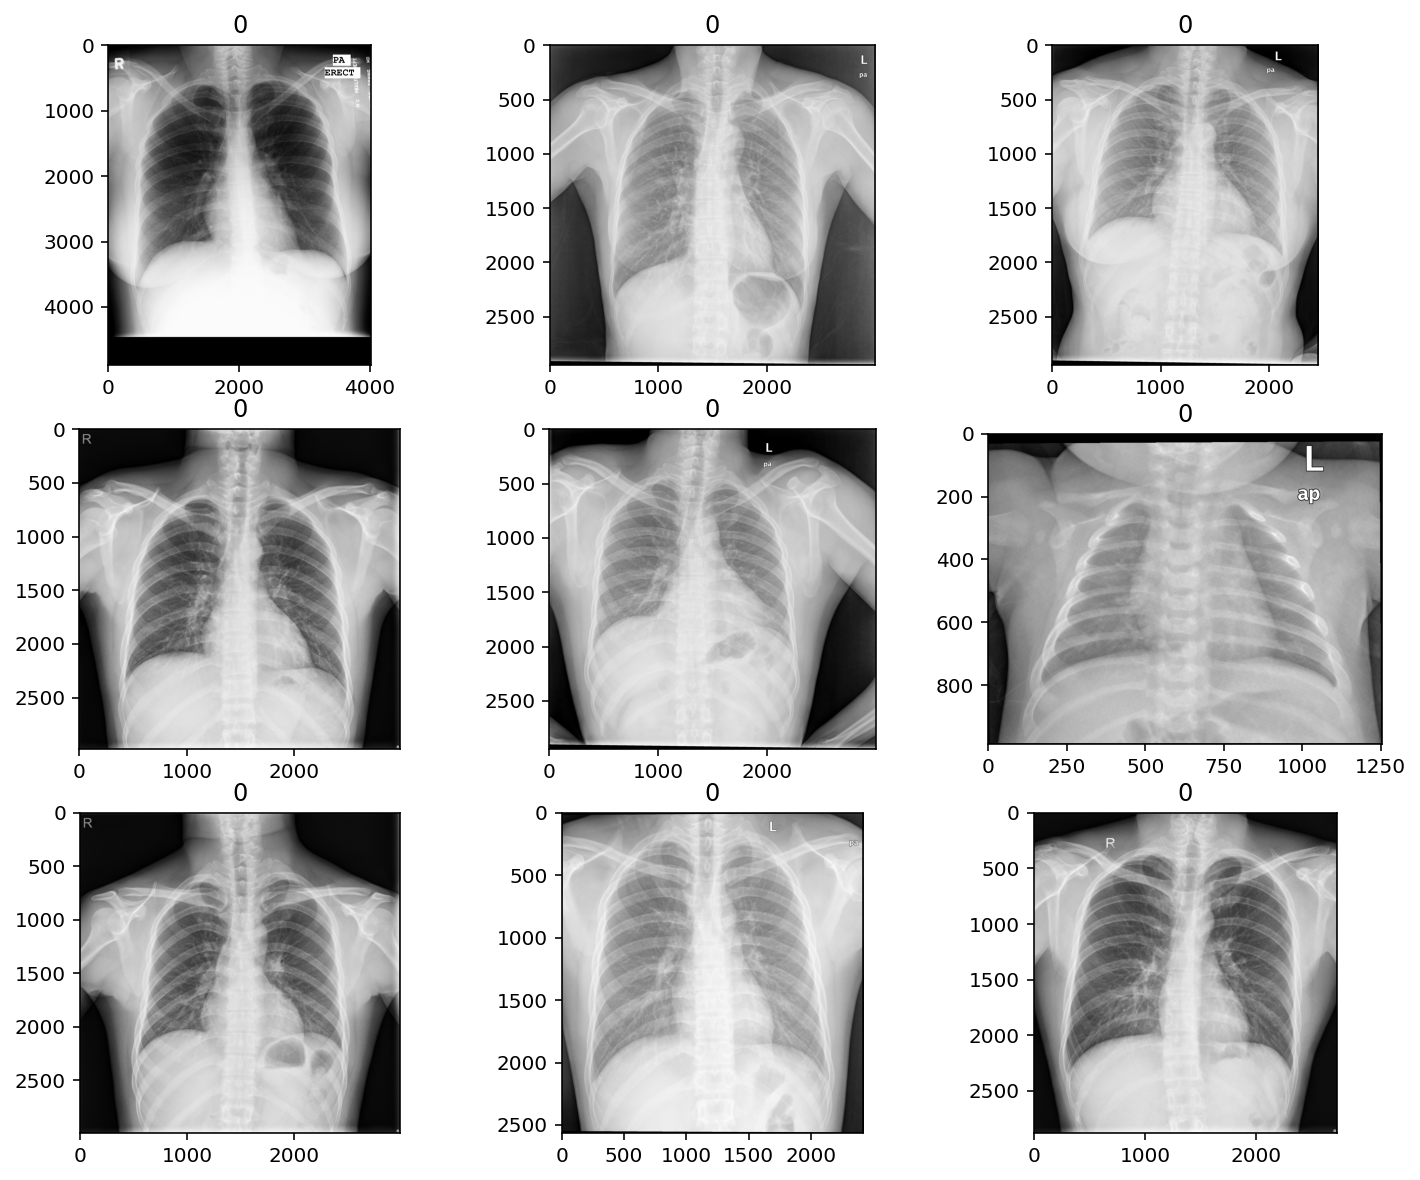

In [8]:
#visualizing random images
nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

# Creating Custom Dataset

In [9]:
class ImageData(Dataset):
    def __init__(self,data_df,images_dir,transform = None):
        self.annotations = data_df
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.images_dir,self.annotations.iloc[index,2]+".png")
        image = Image.open(img_path).convert('RGB')
        img_label = torch.tensor(self.annotations.iloc[index,1])
        #img_dict = {'image':image,'img_label':img_label}
        
        
        if self.transform:
            image = self.transform(image)
        
        return image,img_label

# Image Transformations

In [10]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
#function to create training and validation datasets
def split_indices(len_data,val_pct):
    #creating a list of indices of the data
    dataset_indices = list(range(len_data))
    #shuffling the list of indices
    np.random.shuffle(dataset_indices)
    #creating the split index
    val_split_index = int(np.floor(val_pct * len_data))
    return dataset_indices[val_split_index:],dataset_indices[:val_split_index]

# Prepare DataLoader

In [12]:
#defining our data paths
train_data = ImageData(data_df= train,images_dir='data/train',transform = train_transform)
#validation_data = ImageData(data_df= train,images_dir='data/train',transform = test_transform)
test_data = ImageData(data_df= test,images_dir='data/test',transform = test_transform)

In [13]:
train_idx,val_idx = split_indices(len(train_data),0.2)

In [14]:
#creating the samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(val_idx)

In [15]:
batch_size = 6

dl_train = DataLoader(train_data, batch_size=batch_size, shuffle=False, sampler=train_sampler)
dl_test = DataLoader(train_data, batch_size=batch_size, shuffle=False, sampler= validation_sampler)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 96
Number of test batches 24


# Creating the Model

In [16]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [24]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    #show_images(images, labels, preds)

# Training the Model

In [32]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(dl_test)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 1.0:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [33]:
%%time

train(epochs=7)

Starting training..
Starting epoch 1/7
Evaluating at step 0
Validation Loss: 1.1709, Accuracy: 2.7083
Performance condition satisfied, stopping..
2.7083333333333335
CPU times: user 32.5 s, sys: 335 ms, total: 32.8 s
Wall time: 21.6 s


# Final Results

In [27]:
show_preds()